# LSTM for Meal Detection
### Why LSTM?
RNNs allow us to develop networks that allow us to recognize sequences. They have a feedback loop within their structure allowing them to identify sequences. RNNs suffer from insenstivty to input for long seqences (sequence length approximately greater than 10 time steps) hence, using an LSTM.

### Import Dependencies & Load Data

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load data
cgm_df = pd.read_csv('/content/drive/MyDrive/Capstone/data/synthetic_dataset/20230611_synthetic_T1DB_dataset.csv')

### Clean data

In [3]:
cgm_df.head()

Time      BG         CGM  CHO   insulin  LBGI      HBGI  \
0  2023-06-13 00:00:00  138.56  155.333949  0.0  0.021125   0.0  1.510902   
1  2023-06-13 00:03:00  138.56  151.122022  0.0  0.021125   0.0  1.510902   
2  2023-06-13 00:06:00  138.56  148.779373  0.0  0.021125   0.0  1.510902   
3  2023-06-13 00:09:00  138.56  147.012710  0.0  0.021125   0.0  1.510902   
4  2023-06-13 00:12:00  138.56  145.648950  0.0  0.021125   0.0  1.510902   

       Risk    subject  
0  1.510902  adult#001  
1  1.510902  adult#001  
2  1.510902  adult#001  
3  1.510902  adult#001  
4  1.510902  adult#001

In [4]:
# Create timestamp column
cgm_df['timestamp'] = pd.to_datetime(cgm_df.Time)

# Rename blood glucose to glucose
cgm_df['Glucose'] = cgm_df['CGM']

# Create day column
cgm_df['Time'] = pd.to_datetime(cgm_df['Time'])
cgm_df['Day'] = cgm_df['Time'].dt.day

# Get rid of subjects without data
subjects_to_drop = ['adult#009', 'adult#019', 'adult#029']
cgm_df = cgm_df[~cgm_df['subject'].isin(subjects_to_drop)]

# Create meal indicator
cgm_df['meal'] = np.where(cgm_df['CHO']>0, 1, 0)

# Drop unecessary columns
cgm_df = cgm_df[['Time', 'Glucose', 'Day', 'subject', 'timestamp', 'meal', 'CHO']]

<ipython-input-4-887cf3f90910>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cgm_df['meal'] = np.where(cgm_df['CHO']>0, 1, 0)


In [5]:
cgm_df.head()

Time     Glucose  Day    subject           timestamp  meal  \
0 2023-06-13 00:00:00  155.333949   13  adult#001 2023-06-13 00:00:00     0   
1 2023-06-13 00:03:00  151.122022   13  adult#001 2023-06-13 00:03:00     0   
2 2023-06-13 00:06:00  148.779373   13  adult#001 2023-06-13 00:06:00     0   
3 2023-06-13 00:09:00  147.012710   13  adult#001 2023-06-13 00:09:00     0   
4 2023-06-13 00:12:00  145.648950   13  adult#001 2023-06-13 00:12:00     0   

   CHO  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

### Visualize potential windows
We need to determine the best timesteps for the LSTM. The timesteps hyperparamter, T, determines the amount of historical time the LSTM has learned from at any given point to predict T amount of time into the future. T is the amount of memory we want our network to have. We will want to balance:

*   Having a large enough window to be able to capture the glucose spike that happens after a meal.
*   A small enough window to not capture noise from glucose spikes related to other meals.



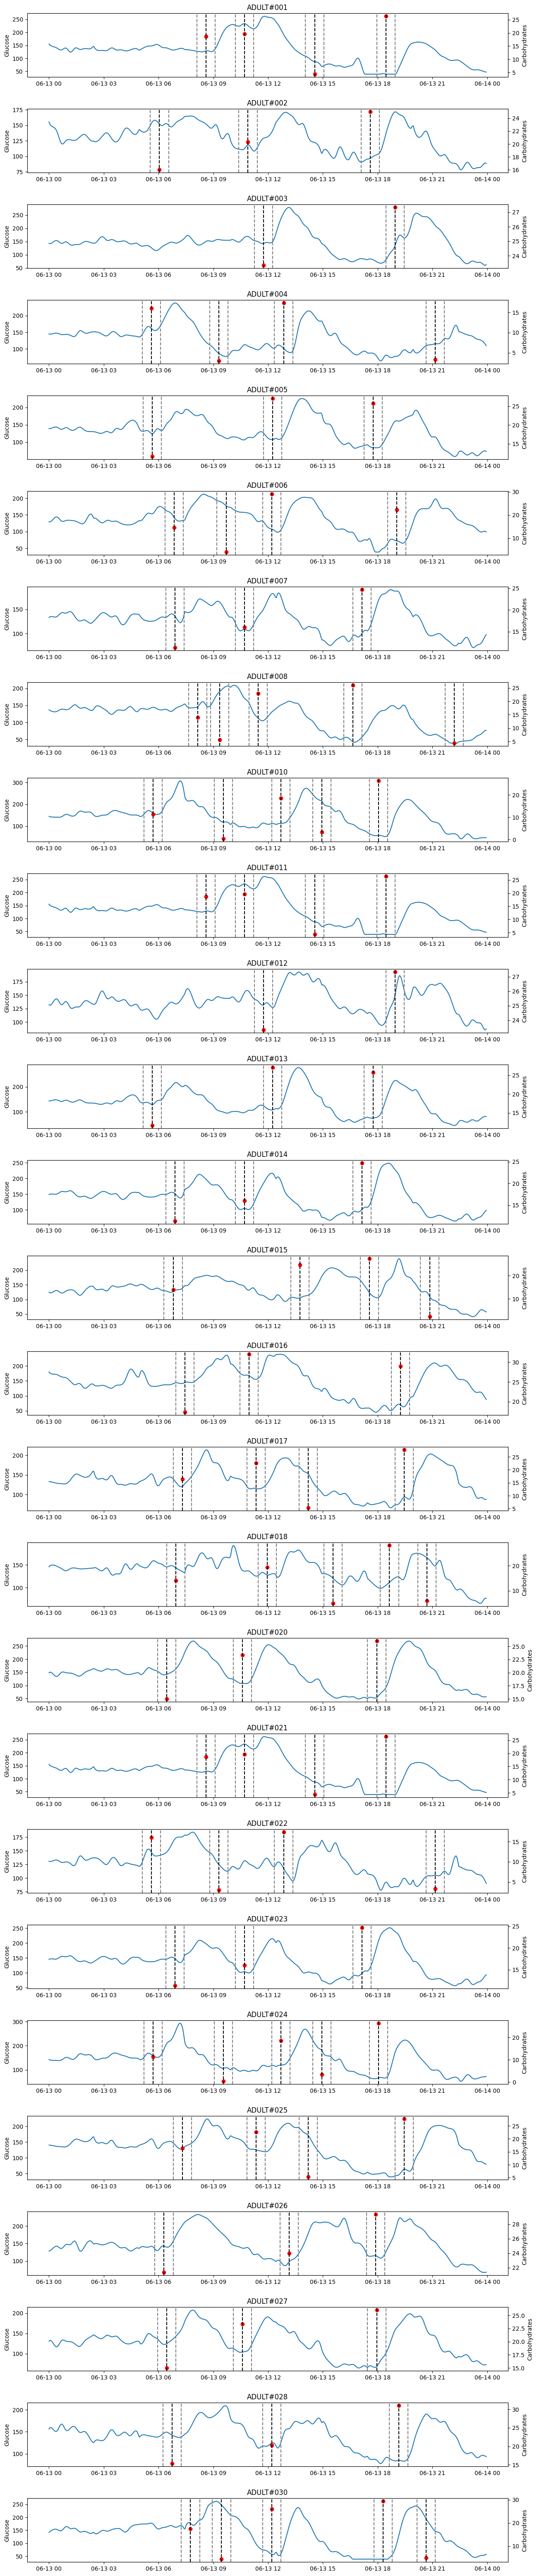

In [6]:
##### 30 minute windows

subjects = cgm_df['subject'].unique().tolist()

cgm_day1 = cgm_df[cgm_df['Day']==13]
cgm_day1.loc[cgm_day1['CHO'] == 0,'CHO'] = np.nan

# define subplot grid
fig, axs = plt.subplots(nrows=27, ncols=1, figsize=(15, 80))
plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Blood Glucose Over Time", fontsize=18, y=0.95)

# loop through tickers and axes
for subject, ax in zip(subjects, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df = cgm_day1[cgm_day1['subject']==subject]
    ax.plot(df['Time'], df['Glucose'])
    ax2 = ax.twinx()
    ax2.scatter(df['Time'], df['CHO'], c='red')

    # chart formatting
    ax.set_title(subject.upper())
    ax.set_xlabel("")
    ax.set_ylabel("Glucose")
    ax2.set_ylabel("Carbohydrates")
    day1_meals = df[df['meal']==1]
    mealtime = day1_meals['Time'].tolist()
    mealtime_plus30 = [x + timedelta(minutes=30) for x in mealtime]
    mealtime_minus30 = [x - timedelta(minutes=30) for x in mealtime]
    for xc in mealtime:
      plt.axvline(x=xc, color='black', linestyle='--')
    for xc in mealtime_plus30:
      plt.axvline(x=xc, color='grey', linestyle='--')
    for xc in mealtime_minus30:
      plt.axvline(x=xc, color='grey', linestyle='--')

plt.show()

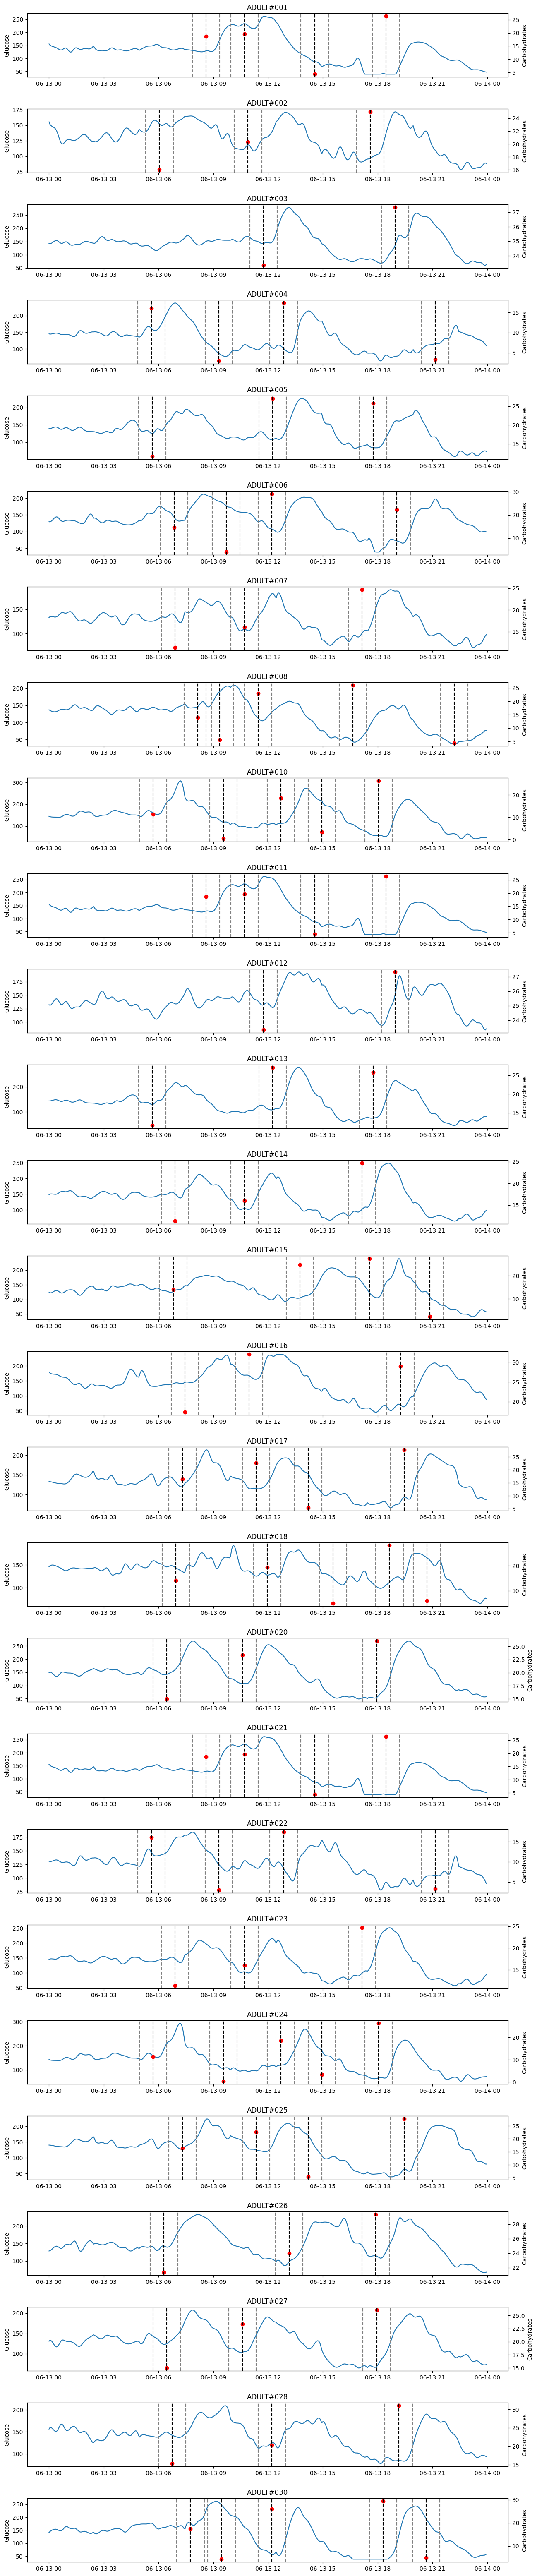

In [7]:
##### 45 minute windows

subjects = cgm_df['subject'].unique().tolist()

cgm_day1 = cgm_df[cgm_df['Day']==13]
cgm_day1.loc[cgm_day1['CHO'] == 0,'CHO'] = np.nan

# define subplot grid
fig, axs = plt.subplots(nrows=27, ncols=1, figsize=(15, 80))
plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Blood Glucose Over Time", fontsize=18, y=0.95)

# loop through tickers and axes
for subject, ax in zip(subjects, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df = cgm_day1[cgm_day1['subject']==subject]
    ax.plot(df['Time'], df['Glucose'])
    ax2 = ax.twinx()
    ax2.scatter(df['Time'], df['CHO'], c='red')

    # chart formatting
    ax.set_title(subject.upper())
    ax.set_xlabel("")
    ax.set_ylabel("Glucose")
    ax2.set_ylabel("Carbohydrates")
    day1_meals = df[df['meal']==1]
    mealtime = day1_meals['Time'].tolist()
    mealtime_plus45 = [x + timedelta(minutes=45) for x in mealtime]
    mealtime_minus45 = [x - timedelta(minutes=45) for x in mealtime]
    for xc in mealtime:
      plt.axvline(x=xc, color='black', linestyle='--')
    for xc in mealtime_plus45:
      plt.axvline(x=xc, color='grey', linestyle='--')
    for xc in mealtime_minus45:
      plt.axvline(x=xc, color='grey', linestyle='--')

plt.show()

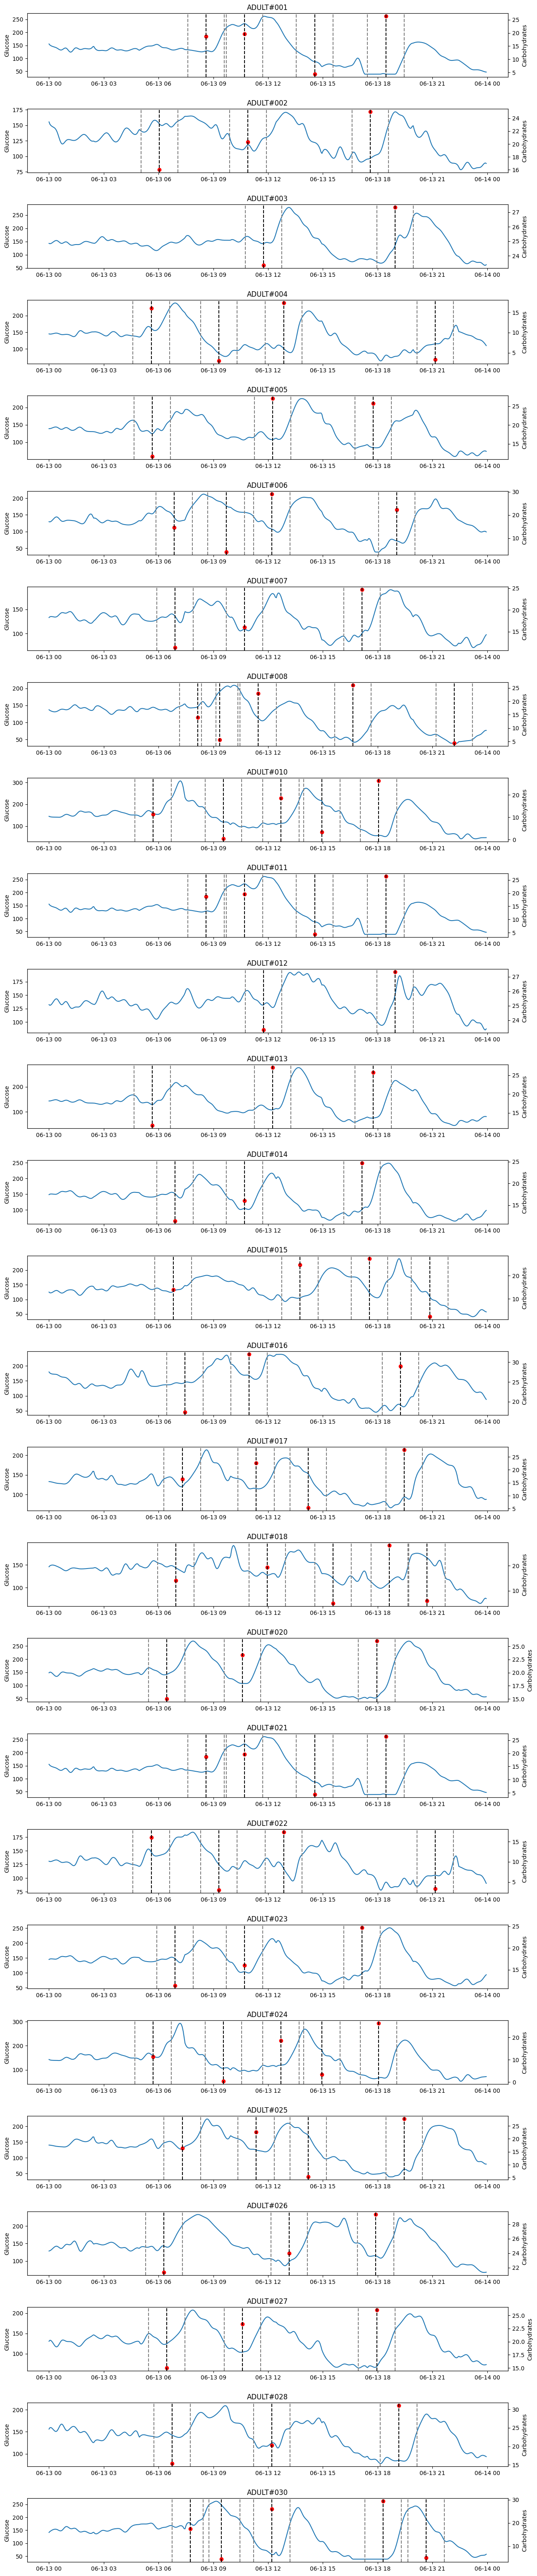

In [8]:
##### 60 minute windows

subjects = cgm_df['subject'].unique().tolist()

cgm_day1 = cgm_df[cgm_df['Day']==13]
cgm_day1.loc[cgm_day1['CHO'] == 0,'CHO'] = np.nan

# define subplot grid
fig, axs = plt.subplots(nrows=27, ncols=1, figsize=(15, 80))
plt.subplots_adjust(hspace=0.5)
#fig.suptitle("Blood Glucose Over Time", fontsize=18, y=0.95)

# loop through tickers and axes
for subject, ax in zip(subjects, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df = cgm_day1[cgm_day1['subject']==subject]
    ax.plot(df['Time'], df['Glucose'])
    ax2 = ax.twinx()
    ax2.scatter(df['Time'], df['CHO'], c='red')

    # chart formatting
    ax.set_title(subject.upper())
    ax.set_xlabel("")
    ax.set_ylabel("Glucose")
    ax2.set_ylabel("Carbohydrates")
    day1_meals = df[df['meal']==1]
    mealtime = day1_meals['Time'].tolist()
    mealtime_plus60 = [x + timedelta(minutes=60) for x in mealtime]
    mealtime_minus60 = [x - timedelta(minutes=60) for x in mealtime]
    for xc in mealtime:
      plt.axvline(x=xc, color='black', linestyle='--')
    for xc in mealtime_plus60:
      plt.axvline(x=xc, color='grey', linestyle='--')
    for xc in mealtime_minus60:
      plt.axvline(x=xc, color='grey', linestyle='--')

plt.show()

### Prepare Data for Modeling

In [9]:
# Data is highly imbalanced
cgm_df.groupby('meal')['Time'].count()

meal
0    192904
1      1523
Name: Time, dtype: int64

In [10]:
# <1% of observations are meal starts
((cgm_df['meal'].sum()) / (cgm_df['meal'].count())) * 100

0.7833274185169756

In [11]:
### Balance data using oversampling

# Separate majority and minority classes
df_majority = cgm_df[cgm_df.meal==0]
df_minority = cgm_df[cgm_df.meal==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.meal.value_counts()

0    192904
1    192904
Name: meal, dtype: int64

In [12]:
# Dimitri's train / test split function
def split_train_test(df):
    # Train test val split on subject ID level
    splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=1)
    split = splitter.split(df, groups=df['subject'])
    train_inds, test_inds = next(split)
    train_df = df.iloc[train_inds]
    test_df = df.iloc[test_inds]
    print(train_df.shape, test_df.shape)
    print('| test_subjects:', test_df.subject.nunique(), '| train_subjects:', train_df.subject.nunique())
    print(sorted(test_df.subject.unique()), sorted(train_df.subject.unique()))
    print('Subjects from train set in test set: ',
          [x for x in train_df.subject.unique() if x in test_df.subject.unique()])

    return train_df, test_df

In [25]:
# Split train and test data
train_df, test_df = split_train_test(df_upsampled)

# Get x train and test data
Xtrain = train_df[['Glucose']]
Xtest = test_df[['Glucose']]

# We want to use 60 minute windows for predicting meals.
# The data is in 3 minute increments, meaning our T = 20
T = 20

prepend_features = Xtrain.iloc[-(T-1):]
Xtest = pd.concat([prepend_features, Xtest], axis=0)

# Get Y train and test data
Ytrain = train_df[['meal']]
Ytest = test_df[['meal']]
#Ytrain = Ytrain.values
#Ytest = Ytest.values

# Scale X train and test data
scaler = StandardScaler()
scaled_Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain.values),
                                     index=Xtrain.index,
                                     columns=Xtrain.columns)
# The Scaler is fit on the training set and then applied to the test set
scaled_Xtest = pd.DataFrame(scaler.transform(Xtest.values),
                                    index=Xtest.index,
                                    columns=Xtest.columns)

scaled_Xtrain.shape, Ytrain.shape, scaled_Xtest.shape, Ytest.shape

(300690, 7) (85118, 7)
| test_subjects: 6 | train_subjects: 21
['adult#004', 'adult#012', 'adult#016', 'adult#020', 'adult#021', 'adult#026'] ['adult#001', 'adult#002', 'adult#003', 'adult#005', 'adult#006', 'adult#007', 'adult#008', 'adult#010', 'adult#011', 'adult#013', 'adult#014', 'adult#015', 'adult#017', 'adult#018', 'adult#022', 'adult#023', 'adult#024', 'adult#025', 'adult#027', 'adult#028', 'adult#030']
Subjects from train set in test set:  []


((300690, 1), (300690, 1), (85137, 1), (85118, 1))

In [26]:
# Create sequences of T timesteps
X_train, y_train = [], []
for i in range(Ytrain.shape[0] - (T-1)):
    X_train.append(scaled_Xtrain.iloc[i:i+T].values)
    y_train.append(Ytrain.iloc[i + (T-1)])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1,1)
print(f'Train data dimensions: {X_train.shape}, {y_train.shape}')

X_test, y_test = [], []
for i in range(Ytest.shape[0]):
    X_test.append(scaled_Xtest.iloc[i:i+T].values)
    y_test.append(Ytest.iloc[i])
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)

print(f'Test data dimensions: {X_test.shape}, {y_test.shape}')

Train data dimensions: (300671, 20, 1), (300671, 1)
Test data dimensions: (85118, 20, 1), (85118, 1)


### Build LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2349/2349 - 38s - loss: 0.4017 - accuracy: 0.8524 - auc: 0.9419 - val_loss: 0.0136 - val_accuracy: 0.9971 - val_auc: 0.9996 - 38s/epoch - 16ms/step
Epoch 2/10
2349/2349 - 24s - loss: 0.0135 - accuracy: 0.9972 - auc: 0.9995 - val_loss: 0.0099 - val_accuracy: 0.9978 - val_auc: 0.9997 - 24s/epoch - 10ms/step
Epoch 3/10
2349/2349 - 21s - loss: 0.0069 - accuracy: 0.9987 - auc: 0.9997 - val_loss: 0.0074 - val_accuracy: 0.9986 - val_auc: 0.9

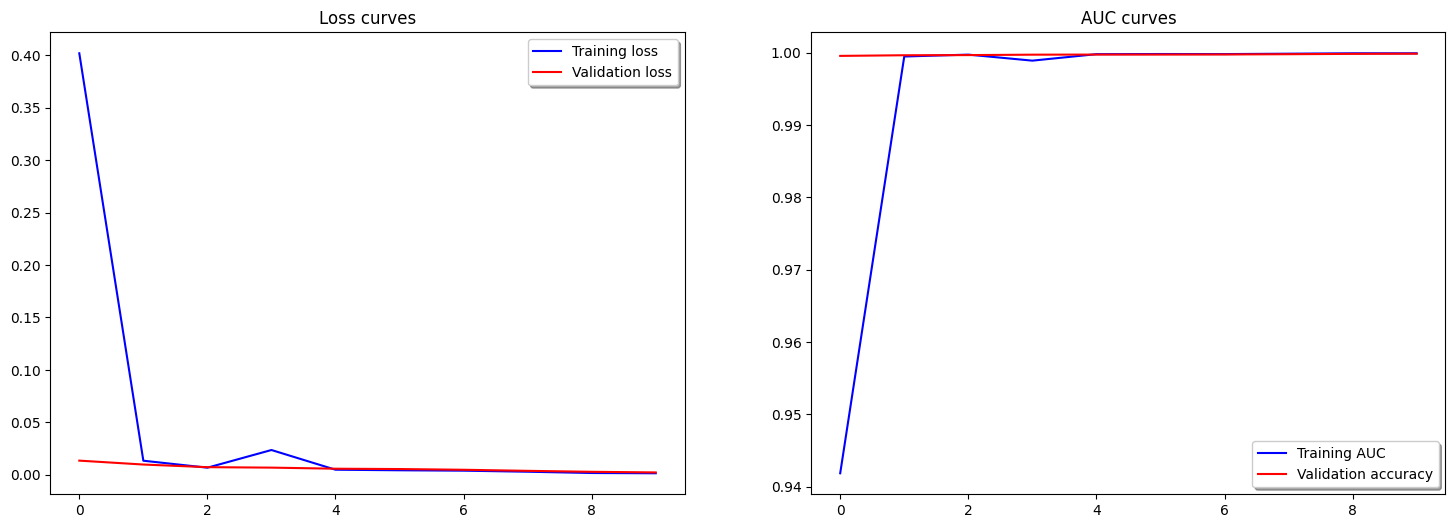

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(T, X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'],
              optimizer='adam')
print(model.summary())

History = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    verbose=2)

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['auc'], color='b', label='Training AUC')
axs[1].plot(History.history['val_auc'], color='r', label='Validation accuracy')
axs[1].set_title("AUC curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [24]:
#y_hat = model.predict_classes(X_test, batch_size=10, verbose=1)
y_hat = (model.predict(X_test) > 0.5).astype("int32")

#score = sum(y_hat == y_test) / len(y_test)

accuracy = sum(y_hat == y_test) / len(y_test)
print(accuracy)

2660/2660 [==============================] - 8s 3ms/step
[0.99976503]
